#Ejercicio realizado por: **Edwin Leonardo Silva Piracoca**

## Librerias

In [1]:
# Se asume que ya las demas librerias estan instaladas

!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Analisis Exploratorio

In [20]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Prueba GBM/Ejercicio 4 /data_customer_classification 1.xlsx'
data = pd.read_excel(file_path)

In [21]:
data.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [23]:
Data_Agrupada = data.groupby('customer_id').agg(
    Frecuencia=('trans_date', 'count'),  # Frecuencia de compra
    Total_Gastado=('tran_amount', 'sum'),  # Sumar el total gastado
    Max_Gastado=('tran_amount', 'max')     # Maximo gastado en una sola transacción
).reset_index()

In [24]:
Data_Agrupada.head()

,customer_id,Frecuencia,Total_Gastado,Max_Gastado
0,CS1112,15,1012,105
1,CS1113,20,1490,98
2,CS1114,19,1432,105
3,CS1115,22,1659,104
4,CS1116,13,857,105


In [25]:
Data_Agrupada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    6889 non-null   object
 1   Frecuencia     6889 non-null   int64 
 2   Total_Gastado  6889 non-null   int64 
 3   Max_Gastado    6889 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 215.4+ KB


In [26]:
Maximo = data['trans_date'].max()

Data_Agrupada['Dia_Ultima_Compra'] = (Maximo - data['trans_date']).dt.days

Data_Agrupada = data.groupby('customer_id').agg(
    Frecuencia=('trans_date', 'count'),  # Contar la cantidad de transacciones (frecuencia de compra)
    Total_Gastado=('tran_amount', 'sum'),  # Sumar el total gastado
    Max_Gastado=('tran_amount', 'max'),    # El máximo gastado en una sola transacción
    Dia_Ultima_Compra=('trans_date', 'count'),  # Cuantos dias ha pasado desde la ultima compra
).reset_index()

Data_Agrupada.head()


,customer_id,Frecuencia,Total_Gastado,Max_Gastado,Dia_Ultima_Compra
0,CS1112,15,1012,105,15
1,CS1113,20,1490,98,20
2,CS1114,19,1432,105,19
3,CS1115,22,1659,104,22
4,CS1116,13,857,105,13


In [27]:
# Ordeno transacciones por cliente
df = data.sort_values(by=['customer_id', 'trans_date'])

# Días entre compras consecutivas.
df['fecha_anterior'] = df.groupby('customer_id')['trans_date'].shift(1)
df['dias_transcurridos'] = (df['trans_date'] - df['fecha_anterior']).dt.days

# En este caso se saca la desviacion estandar para calcular el promedio de dias con el que el cliente realiza compras
Regularidad = df.groupby('customer_id')['dias_transcurridos'].std().reset_index()
Regularidad.rename(columns={'dias_transcurridos': 'Promedio_Dias_Compra'}, inplace=True)

Data_Agrupada = Data_Agrupada.merge(Regularidad, on='customer_id', how='left')
Data_Agrupada['Promedio_Dias_Compra'].fillna(0, inplace=True)

Data_Agrupada.head()


,customer_id,Frecuencia,Total_Gastado,Max_Gastado,Dia_Ultima_Compra,Promedio_Dias_Compra
0,CS1112,15,1012,105,15,50.873523
1,CS1113,20,1490,98,20,54.685812
2,CS1114,19,1432,105,19,73.693168
3,CS1115,22,1659,104,22,55.413425
4,CS1116,13,857,105,13,107.361010


In [31]:
Data_Agrupada.head().to_excel('/content/drive/MyDrive/Colab Notebooks/Prueba GBM/Ejercicio 4 /Data_Prueba.xlsx', index=False)

In [29]:
Data_Agrupada.head()

,customer_id,Frecuencia,Total_Gastado,Max_Gastado,Dia_Ultima_Compra,Promedio_Dias_Compra
0,CS1112,15,1012,105,15,50.873523
1,CS1113,20,1490,98,20,54.685812
2,CS1114,19,1432,105,19,73.693168
3,CS1115,22,1659,104,22,55.413425
4,CS1116,13,857,105,13,107.361010


In [36]:
Data_Agrupada['Total_Gastado'].quantile(0.66)

1414.0

In [32]:
Umbral_bajo = Data_Agrupada['Total_Gastado'].quantile(0.33)
Umbral_medio = Data_Agrupada['Total_Gastado'].quantile(0.66)

# Función para clasificar los clientes basado en el total gastado
def clasificacion_umbral(X):
    if X <= Umbral_bajo:
        return 'Bajo'

    elif X <= Umbral_medio:
        return 'Medio'
    else:
        return 'Alto'

# Aplicar la clasificación a los datos
Data_Agrupada['Clasificacion'] = Data_Agrupada['Total_Gastado'].apply(clasificacion_umbral)

Data_Agrupada.head()


,customer_id,Frecuencia,Total_Gastado,Max_Gastado,Dia_Ultima_Compra,Promedio_Dias_Compra,Clasificacion
0,CS1112,15,1012,105,15,50.873523,Medio
1,CS1113,20,1490,98,20,54.685812,Alto
2,CS1114,19,1432,105,19,73.693168,Alto
3,CS1115,22,1659,104,22,55.413425,Alto
4,CS1116,13,857,105,13,107.361010,Bajo


In [12]:
Data_Agrupada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           6889 non-null   object 
 1   Frecuencia            6889 non-null   int64  
 2   Total_Gastado         6889 non-null   int64  
 3   Max_Gastado           6889 non-null   int64  
 4   Dia_Ultima_Compra     6889 non-null   int64  
 5   Promedio_Dias_Compra  6889 non-null   float64
 6   Clasificacion         6889 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 376.9+ KB


## Split y codificación

In [13]:
#Codificacion encoder
encoder = OneHotEncoder(sparse=False)
Y_encoded = encoder.fit_transform(Data_Agrupada[['Clasificacion']])

# Normalizar
scaler = StandardScaler()
Data_Agrupada_scaled = scaler.fit_transform(Data_Agrupada[['Frecuencia', 'Total_Gastado', 'Max_Gastado', 'Dia_Ultima_Compra','Promedio_Dias_Compra']])

X_train, X_test, y_train, y_test = train_test_split(Data_Agrupada_scaled, Y_encoded, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
Data_Agrupada[['Frecuencia', 'Total_Gastado', 'Max_Gastado', 'Dia_Ultima_Compra','Promedio_Dias_Compra']]


,Frecuencia,Total_Gastado,Max_Gastado,Dia_Ultima_Compra,Promedio_Dias_Compra
0,15,1012,105,15,50.873523
1,20,1490,98,20,54.685812
2,19,1432,105,19,73.693168
3,22,1659,104,22,55.413425
4,13,857,105,13,107.361010
...,...,...,...,...,...
6884,13,582,79,13,100.650912
6885,14,543,75,14,77.791223
6886,13,624,79,13,109.644985
6887,12,383,64,12,55.000661


## Estructura Red Neuronal y entrenamiento

In [ ]:
# Número de características de entrada
input_dim = X_train.shape[1]

# Número de clases de salida (bajo, medio, alto)
output_dim = y_train.shape[1]

model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(output_dim, activation='softmax')
])
#Tasa de aprendizaje

optimizer = Adam()
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               768       
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 16)               

In [ ]:
#Entrenamiento
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=8,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    validation_split=0.2)

Epoch 1/50
689/689 [==============================] - 3s 3ms/step - loss: 1.6103 - accuracy: 0.5282 - val_loss: 0.9431 - val_accuracy: 0.6945
Epoch 2/50
689/689 [==============================] - 2s 3ms/step - loss: 0.8753 - accuracy: 0.7099 - val_loss: 0.7003 - val_accuracy: 0.7961
Epoch 3/50
689/689 [==============================] - 2s 3ms/step - loss: 0.6988 - accuracy: 0.8381 - val_loss: 0.5468 - val_accuracy: 0.9202
Epoch 4/50
689/689 [==============================] - 2s 3ms/step - loss: 0.6001 - accuracy: 0.8699 - val_loss: 0.4558 - val_accuracy: 0.9615
Epoch 5/50
689/689 [==============================] - 2s 3ms/step - loss: 0.5581 - accuracy: 0.8723 - val_loss: 0.4248 - val_accuracy: 0.9412
Epoch 6/50
689/689 [==============================] - 2s 3ms/step - loss: 0.5399 - accuracy: 0.8762 - val_loss: 0.3847 - val_accuracy: 0.9579
Epoch 7/50
689/689 [==============================] - 2s 3ms/step - loss: 0.5101 - accuracy: 0.8828 - val_loss: 0.3797 - val_accuracy: 0.9521
Epoch 

## Metricas de deseempeño

In [ ]:
# Predicciones
y_pred = model.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(true_classes, predicted_classes))

44/44 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       461
           1       1.00      0.99      0.99       442
           2       0.98      0.95      0.97       475

    accuracy                           0.98      1378
   macro avg       0.98      0.98      0.98      1378
weighted avg       0.98      0.98      0.98      1378



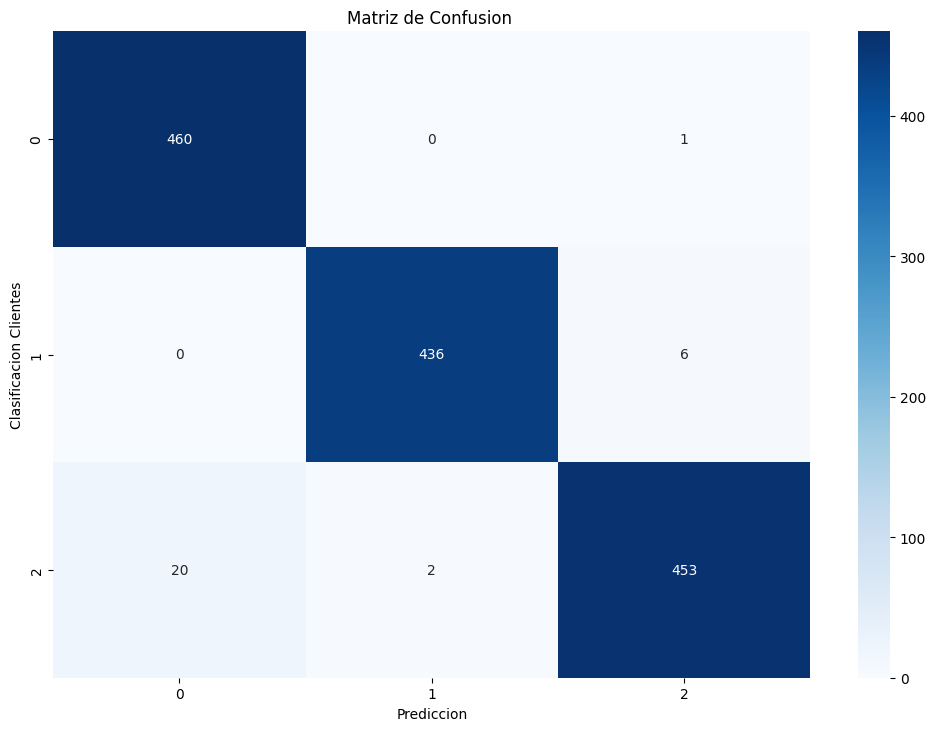

In [ ]:
Matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,7))
sns.heatmap(Matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.tight_layout()
plt.title('Matriz de Confusion ')
plt.ylabel('Clasificacion Clientes')
plt.xlabel('Prediccion')
plt.show()


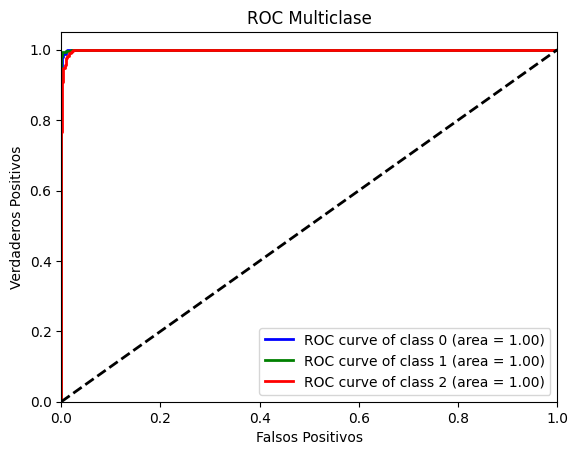

In [ ]:
#Curva roc para los tres casos

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(output_dim):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(output_dim), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('ROC Multiclase')
plt.legend(loc="lower right")
plt.show()


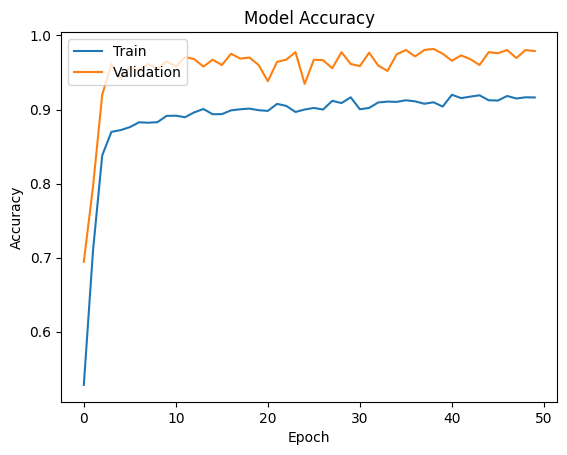

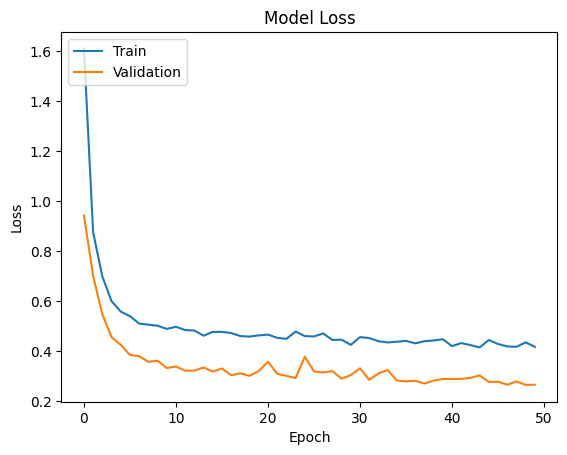

In [ ]:
#Precision y perdida del modelo con el pasar de las epocas

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Guardar el modelo Keras

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Prueba GBM/Ejercicio 4 - Modelo/modelo_keras.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Cargar el modelo Keras

In [ ]:
modelo_cargado = load_model('/content/drive/MyDrive/Colab Notebooks/Prueba GBM/Ejercicio 4 - Modelo/modelo_keras.h5')

## Predición respecto a X_TEST

In [ ]:
# Evaluar el modelo cargado
loss, accuracy = modelo_cargado.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Hacer predicciones
predicciones = modelo_cargado.predict(X_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.2653 - accuracy: 0.9790
Loss: 0.26529306173324585, Accuracy: 0.9789550304412842
44/44 [==============================] - 0s 1ms/step


In [ ]:
print(predicciones)

[[6.01671124e-03 8.32343280e-01 1.61639988e-01]
 [3.77570675e-03 8.90244663e-01 1.05979584e-01]
 [8.87645558e-02 1.03701430e-04 9.11131740e-01]
 ...
 [1.77331835e-01 7.14324173e-08 8.22668076e-01]
 [3.77570675e-03 8.90244663e-01 1.05979584e-01]
 [9.99997854e-01 0.00000000e+00 2.10456278e-06]]


In [ ]:
clases_predichas_indices = np.argmax(predicciones, axis=1)
print(clases_predichas_indices)

# Definir las etiquetas
etiquetas = ['Bajo', 'Medio', 'Alto']

# Mapear índices a etiquetas
clases_predichas_etiquetas = [etiquetas[i] for i in clases_predichas_indices]

# Imprimir las etiquetas predichas
print(clases_predichas_etiquetas)

[1 1 2 ... 2 1 0]
['Medio', 'Medio', 'Alto', 'Alto', 'Medio', 'Alto', 'Medio', 'Medio', 'Bajo', 'Bajo', 'Medio', 'Alto', 'Medio', 'Bajo', 'Medio', 'Alto', 'Alto', 'Alto', 'Alto', 'Medio', 'Bajo', 'Bajo', 'Alto', 'Medio', 'Medio', 'Alto', 'Bajo', 'Medio', 'Bajo', 'Alto', 'Alto', 'Medio', 'Alto', 'Bajo', 'Bajo', 'Bajo', 'Alto', 'Bajo', 'Medio', 'Medio', 'Alto', 'Bajo', 'Bajo', 'Medio', 'Alto', 'Medio', 'Medio', 'Medio', 'Alto', 'Bajo', 'Medio', 'Bajo', 'Medio', 'Medio', 'Alto', 'Bajo', 'Bajo', 'Medio', 'Alto', 'Alto', 'Alto', 'Alto', 'Bajo', 'Medio', 'Alto', 'Bajo', 'Alto', 'Medio', 'Bajo', 'Bajo', 'Alto', 'Alto', 'Bajo', 'Alto', 'Bajo', 'Bajo', 'Medio', 'Alto', 'Bajo', 'Alto', 'Bajo', 'Medio', 'Alto', 'Alto', 'Medio', 'Alto', 'Medio', 'Alto', 'Bajo', 'Medio', 'Alto', 'Bajo', 'Medio', 'Medio', 'Alto', 'Alto', 'Bajo', 'Medio', 'Medio', 'Alto', 'Bajo', 'Alto', 'Bajo', 'Medio', 'Bajo', 'Bajo', 'Bajo', 'Alto', 'Medio', 'Medio', 'Medio', 'Bajo', 'Alto', 'Alto', 'Medio', 'Bajo', 'Alto', 'Alto'

## Validacion Cruzada con el fin de evaluar un posible SobreAjuste

In [14]:
# Preparar KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Listas para guardar los resultados
acc_per_fold = []
loss_per_fold = []
fold_no = 1

# Dataframe para guardar los resultados de cada fold
results_df = pd.DataFrame(columns=['Fold', 'Loss', 'Accuracy'])

for train, test in kfold.split(Data_Agrupada_scaled, Y_encoded):
    # Crear el modelo
    model_fold = Sequential([
        Dense(128, input_dim=Data_Agrupada_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(Y_encoded.shape[1], activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model_fold.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    history_fold = model_fold.fit(Data_Agrupada_scaled[train],
                                  Y_encoded[train],
                                  epochs=50,
                                  batch_size=8,
                                  verbose=1,
                                  validation_data=(Data_Agrupada_scaled[test], Y_encoded[test]))

    scores = model_fold.evaluate(Data_Agrupada_scaled[test], Y_encoded[test], verbose=0)
    print(f'Score for fold {fold_no}: {model_fold.metrics_names[0]} of {scores[0]}; {model_fold.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    new_row = pd.DataFrame({'Fold': [fold_no], 'Loss': [scores[0]], 'Accuracy': [scores[1]*100]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    fold_no += 1

print(results_df)

print('------------------------------------------------------------------------')
print('Estadísticas de validación cruzada:')
print(f'> Accuracy promedio: {results_df["Accuracy"].mean():.2f}% (+- {results_df["Accuracy"].std():.2f})')
print(f'> Loss promedio: {results_df["Loss"].mean():.2f}')
print('------------------------------------------------------------------------')

Epoch 1/50
775/775 [==============================] - 4s 3ms/step - loss: 1.4746 - accuracy: 0.5755 - val_loss: 0.6827 - val_accuracy: 0.8708
Epoch 2/50
775/775 [==============================] - 2s 2ms/step - loss: 0.7110 - accuracy: 0.8239 - val_loss: 0.4544 - val_accuracy: 0.9216
Epoch 3/50
775/775 [==============================] - 2s 2ms/step - loss: 0.6179 - accuracy: 0.8408 - val_loss: 0.3902 - val_accuracy: 0.9550
Epoch 4/50
775/775 [==============================] - 2s 2ms/step - loss: 0.5798 - accuracy: 0.8498 - val_loss: 0.3635 - val_accuracy: 0.9652
Epoch 5/50
775/775 [==============================] - 2s 2ms/step - loss: 0.5479 - accuracy: 0.8644 - val_loss: 0.3361 - val_accuracy: 0.9666
Epoch 6/50
775/775 [==============================] - 2s 2ms/step - loss: 0.5472 - accuracy: 0.8585 - val_loss: 0.3267 - val_accuracy: 0.9768
Epoch 7/50
775/775 [==============================] - 2s 2ms/step - loss: 0.5289 - accuracy: 0.8598 - val_loss: 0.3182 - val_accuracy: 0.9739
Epoch 

In [15]:
results_df

,Fold,Loss,Accuracy
0,1,0.224136,98.113209
1,2,0.268906,95.791000
2,3,0.242884,97.097242
3,4,0.278360,96.952105
4,5,0.278934,95.500726
5,6,0.262789,97.677791
6,7,0.274125,97.097242
7,8,0.241866,98.403484
8,9,0.241897,97.387516
9,10,0.236329,97.819769
